In [65]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from environment import Environment
from actor import Actor
from copy import deepcopy
from tqdm import tqdm
from utils import make_simulation_plot, run_environment_simulation, calculate_loss

In [89]:
n_samples_train = 500
n_samples_test = 50
n_locations = 5
n_steps = n_locations * 2
max_demand = 10
max_capacity = 50
n_epochs = 150
approximation_level = 10

model_actor = Actor(n_locations)
optimizer = tf.keras.optimizers.legacy.Adam()

env_org = Environment(n_samples_train, n_locations, max_demand, max_capacity)
env_test = Environment(n_samples_test, n_locations, max_demand, max_capacity)

In [90]:
grads_lst = []
losses_train = []
losses_test = []

all_actions_real_train = []
all_actions_real_test = []

all_actions_approximation_train = []
all_actions_approximation_test = []

In [ ]:
for _ in tqdm(range(n_epochs)):
    env_train = deepcopy(env_org)
    env_test_process = deepcopy(env_test)
    with tf.GradientTape(persistent=True) as tape:

        actions_approximation_train, actions_real_train = run_environment_simulation(
            env_train, model_actor, n_steps, approximation_level
        )
        actions_approximation_test, actions_real_test = run_environment_simulation(
            env_test_process, model_actor, n_steps, approximation_level
        )

        loss_train = calculate_loss(tf.convert_to_tensor(actions_approximation_train))
        loss_test = calculate_loss(tf.convert_to_tensor(actions_approximation_test))
        
        losses_train.append(loss_train)
        losses_test.append(loss_test)

    all_actions_approximation_train.append(actions_approximation_train)
    all_actions_approximation_test.append(actions_approximation_test)

    all_actions_real_train.append(actions_real_train) 
    all_actions_real_test.append(actions_real_test)    

    grads = tape.gradient(loss_train, model_actor.trainable_variables)
    grads_and_vars = zip(grads, model_actor.trainable_variables)
    optimizer.apply_gradients(grads_and_vars)
    grads_lst.append(grads)

 45%|████▍     | 67/150 [00:50<01:04,  1.29it/s]

In [110]:
tf_all_actions_approximation_train = tf.convert_to_tensor(all_actions_approximation_train)
tf_all_actions_approximation_test = tf.convert_to_tensor(all_actions_approximation_test)

tf_all_actions_real_train = tf.convert_to_tensor(all_actions_real_train)
tf_all_actions_real_test = tf.convert_to_tensor(all_actions_real_test)
# shape: [n_epochs x n_steps x n_samples x 2]

In [111]:
tf.reduce_mean(tf_all_actions_approximation_train - tf_all_actions_real_train)

<tf.Tensor: shape=(), dtype=float32, numpy=0.00031584722>

In [112]:
tf.reduce_mean(tf_all_actions_approximation_train - tf_all_actions_real_train)

<tf.Tensor: shape=(), dtype=float32, numpy=0.00031584722>

In [113]:
def fun(ls, n):
    return [np.mean(ls[i:i+n]) for i in range(0, len(ls) - n)]

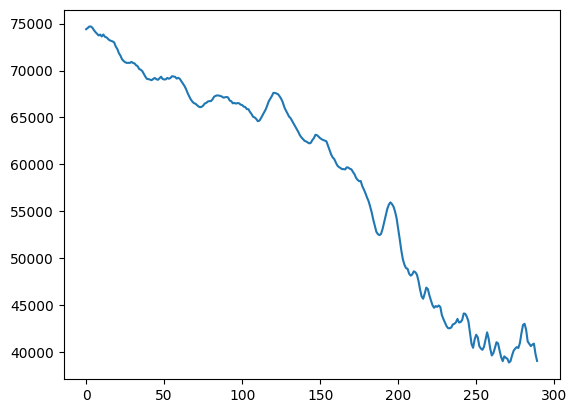

In [115]:
plt.plot(fun(losses_train, 10))
plt.show()

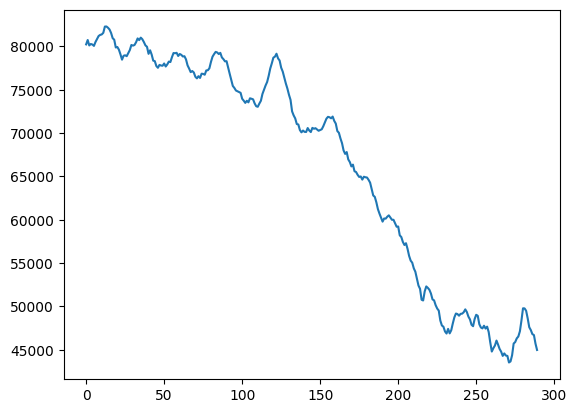

In [117]:
plt.plot(fun(losses_test, 10))
plt.show()
# plt.ylim([0, 250])

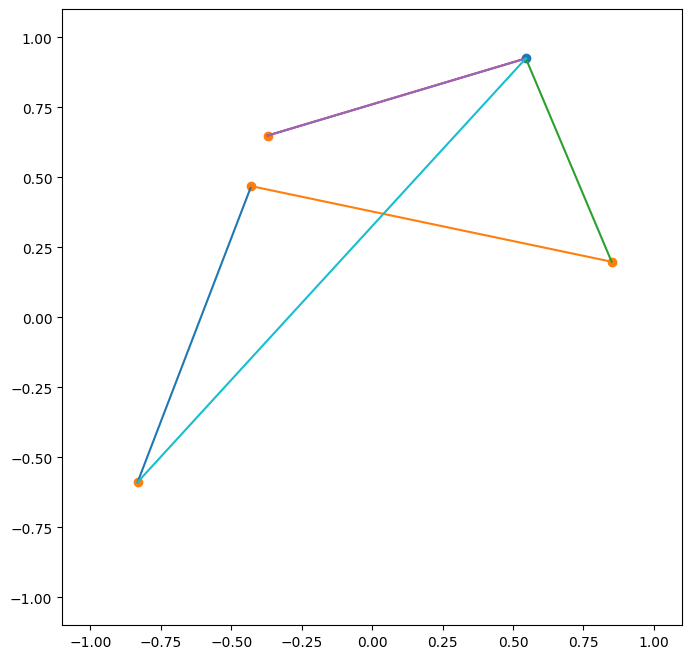

In [124]:
sample_id = 50
epoch_id = 0

# l1 = calculate_loss(tf_all_actions_real[epoch_id, :, sample_id:sample_id+1, :])
# print(l1.numpy())
make_simulation_plot(env_train.locations[sample_id], tf_all_actions_real_train[epoch_id, :, sample_id])

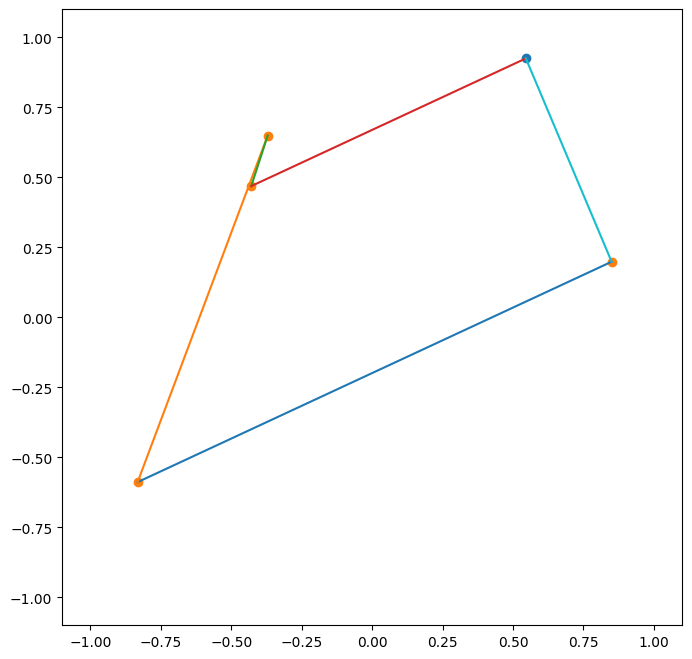

In [125]:
epoch_id = -1

# l1 = calculate_loss(tf_all_actions_real[epoch_id, :, sample_id:sample_id+1, :])
# print(l1.numpy())
make_simulation_plot(env_train.locations[sample_id], tf_all_actions_real_train[epoch_id, :, sample_id])